# Week 2_1: Features and metrics for nearest neighbor 

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically

- Decide on a notion of similarity
- Find the documents that are most similar

In the assignment you will
- Gain intuition for different notions of similarity and practice finding similar documents.
- Explore the tradeoffs with representing documents using raw word counts and TF-IDF
- Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [115]:
import sframe
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

%matplotlib inline

In [116]:
wiki = sframe.SFrame('people_wiki.gl/')

In [117]:
wiki = wiki.add_row_number()

In [118]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix((data, indices, indptr), shape)

* We use the pre-computed word count vectors here. We can also generate it with 'sklearn.CountVectorizer'

In [119]:
word_count = load_sparse_csr('people_wiki_word_count.npz')

In [120]:
map_index_to_word = sframe.SFrame('people_wiki_map_index_to_word.gl/')

# Find the NN using word count vectors

In [121]:
from sklearn.neighbors import NearestNeighbors

In [122]:
model = NearestNeighbors(metric='euclidean', algorithm='brute')

In [123]:
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [124]:
print wiki[wiki['name'] == 'Barack Obama']

+-------+-------------------------------+--------------+
|   id  |              URI              |     name     |
+-------+-------------------------------+--------------+
| 35817 | <http://dbpedia.org/resour... | Barack Obama |
+-------+-------------------------------+--------------+
+-------------------------------+
|              text             |
+-------------------------------+
| barack hussein obama ii br... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [125]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10)

In [126]:
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})

print wiki.join(neighbors, on='id').sort('distance')[['id','name','distance']]

+-------+----------------------------+---------------+
|   id  |            name            |    distance   |
+-------+----------------------------+---------------+
| 35817 |        Barack Obama        |      0.0      |
| 24478 |         Joe Biden          | 33.0756708171 |
| 28447 |       George W. Bush       | 34.3947670438 |
| 35357 |      Lawrence Summers      | 36.1524549651 |
| 14754 |        Mitt Romney         | 36.1662826401 |
| 13229 |      Francisco Barrio      | 36.3318042492 |
| 31423 |       Walter Mondale       | 36.4005494464 |
| 22745 | Wynn Normington Hugh-Jones | 36.4965751818 |
| 36364 |         Don Bonker         |  36.633318168 |
|  9210 |        Andy Anstett        | 36.9594372252 |
+-------+----------------------------+---------------+
[10 rows x 3 columns]



# Understand 'Francisco Barrio'

In [127]:
def unpack_dict(matrix, map_index_to_word):
    table = list(map_index_to_word.sort('index')['category'])
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in xrange(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [128]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return word_count_table.sort('count', ascending=False)

obama_words = top_words('Barack Obama')
print obama_words

barrio_words = top_words('Francisco Barrio')
print barrio_words

+-------+-------+
|  word | count |
+-------+-------+
|  the  |   40  |
|   in  |   30  |
|  and  |   21  |
|   of  |   18  |
|   to  |   14  |
|  his  |   11  |
| obama |   9   |
|  act  |   8   |
|   a   |   7   |
|   he  |   7   |
+-------+-------+
[273 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
+-----------+-------+
|    word   | count |
+-----------+-------+
|    the    |   36  |
|     of    |   24  |
|    and    |   18  |
|     in    |   17  |
|     he    |   10  |
|     to    |   9   |
| chihuahua |   7   |
|     a     |   6   |
|  governor |   6   |
|     as    |   5   |
+-----------+-------+
[225 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [129]:
combined_words = obama_words.join(barrio_words, on='word')

In [130]:
combined_words = combined_words.rename({'count': 'Obama', 'count.1': 'Barrio'})

In [131]:
combined_words.sort('Obama', ascending=False)

word,Obama,Barrio
the,40,36
in,30,17
and,21,18
of,18,24
to,14,9
his,11,5
a,7,6
he,7,10
as,6,5
was,5,4


* Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama.

# Next question: How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [132]:
common_words = set(['the', 'and', 'of', 'to', 'in']) 

In [133]:
common_words = set(['the', 'and', 'of', 'to', 'in'])  # YOUR CODE HERE

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)  # YOUR CODE HERE

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
wiki['has_top_words'].sum() # YOUR CODE HERE




56066

# Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

* 35817 Barack Obama   
* 24478 Joe Biden 
* 28447 George W. Bush

In [61]:
word_count[35817]

<1x547979 sparse matrix of type '<type 'numpy.int64'>'
	with 273 stored elements in Compressed Sparse Row format>

In [62]:
from sklearn.metrics.pairwise import euclidean_distances

In [63]:
euclidean_distances(word_count[35817], word_count[24478])

array([[ 33.07567082]])

In [64]:
euclidean_distances(word_count[35817], word_count[28447])

array([[ 34.39476704]])

In [65]:
euclidean_distances(word_count[24478], word_count[28447])

array([[ 32.75667871]])

In [67]:
print 'Answer: Biden and Bush, d = 32.75667871'

Answer: Biden and Bush, d = 32.75667871


# Collect all words that appear both in Barack Obama and George W. Bush pages. Out of those words, find the 10 words that show up most often in Obama's page.

In [68]:
obama_words = top_words('Barack Obama')
print obama_words

bush_words = top_words('George W. Bush')
print bush_words

+-------+-------+
|  word | count |
+-------+-------+
|  the  |   40  |
|   in  |   30  |
|  and  |   21  |
|   of  |   18  |
|   to  |   14  |
|  his  |   11  |
| obama |   9   |
|  act  |   8   |
|   a   |   7   |
|   he  |   7   |
+-------+-------+
[273 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
+-----------+-------+
|    word   | count |
+-----------+-------+
|    the    |   39  |
|     in    |   22  |
|    and    |   14  |
|     of    |   14  |
|    bush   |   12  |
|     to    |   11  |
|     he    |   8   |
|     a     |   6   |
|     as    |   6   |
| president |   6   |
+-----------+-------+
[288 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [73]:
combined_words2 = obama_words.join(bush_words, on='word')
combined_words2 = combined_words2.rename({'count': 'Obama', 'count.1': 'Bush'})
combined_words2.sort('Obama', ascending=False)

word,Obama,Bush
the,40,39
in,30,22
and,21,14
of,18,14
to,14,11
his,11,6
act,8,3
a,7,6
he,7,8
law,6,1


# Extract the TF-IDF vectors

* alternative to use sklearn.TfidfVectorizer

In [76]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [78]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [82]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')

In [83]:
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [84]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

In [86]:
indices

array([[35817,  7914, 46811, 44681, 38376,  6507, 38714, 44825, 44368,
        33417]])

In [87]:
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
print wiki.join(neighbors, on='id').sort('distance')[['id', 'name', 'distance']]

+-------+-------------------------+---------------+
|   id  |           name          |    distance   |
+-------+-------------------------+---------------+
| 35817 |       Barack Obama      |      0.0      |
|  7914 |      Phil Schiliro      | 106.861013691 |
| 46811 |      Jeff Sessions      | 108.871674216 |
| 44681 |  Jesse Lee (politician) | 109.045697909 |
| 38376 |      Samantha Power     | 109.108106165 |
|  6507 |       Bob Menendez      | 109.781867105 |
| 38714 | Eric Stern (politician) |  109.95778808 |
| 44825 |      James A. Guest     | 110.413888718 |
| 44368 |   Roland Grossenbacher  |  110.4706087  |
| 33417 |      Tulsi Gabbard      | 110.696997999 |
+-------+-------------------------+---------------+
[10 rows x 3 columns]



In [88]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_table = row[['tf_idf']].stack('tf_idf', new_column_name=['word','weight'])
    return word_count_table.sort('weight', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print obama_tf_idf

schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
print schiliro_tf_idf

+-------------+---------------+
|     word    |     weight    |
+-------------+---------------+
|    obama    | 43.2956530721 |
|     act     |  27.678222623 |
|     iraq    |  17.747378588 |
|   control   | 14.8870608452 |
|     law     | 14.7229357618 |
|   ordered   | 14.5333739509 |
|   military  | 13.1159327785 |
|   response  | 12.7843852412 |
| involvement | 12.7843852412 |
|  democratic | 12.4106886973 |
+-------------+---------------+
[273 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
+-----------------+---------------+
|       word      |     weight    |
+-----------------+---------------+
|     schiliro    | 21.9729907785 |
|      staff      | 15.8564416352 |
|  congressional  | 13.5470876563 |
| daschleschiliro | 10.9864953892 |
|      obama      | 9.62125623824 |
|      waxman     | 9.04058524017 |
|    president    | 9.03358661416 |
|     2014from    | 8.68391029623 |
|    

In [91]:
combined_words3 = obama_tf_idf.join(schiliro_tf_idf, on='word')
combined_words3 = combined_words3.rename({'weight': 'Obama', 'weight.1': 'Schiliro'})
combined_words3.sort('Obama', ascending=False)

word,Obama,Schiliro
obama,43.2956530721,9.62125623824
law,14.7229357618,7.36146788088
democratic,12.4106886973,6.20534434867
senate,10.1642881797,3.3880960599
presidential,7.3869554189,3.69347770945
president,7.22686929133,9.03358661416
policy,6.09538628214,3.04769314107
states,5.47320098963,1.82440032988
office,5.24817282322,2.62408641161
2011,5.10704127031,3.40469418021


* Quiz Question. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [93]:
common_words = set(['obama', 'law', 'democratic', 'senate', 'presidential'])  # YOUR CODE HERE

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)  # YOUR CODE HERE

wiki['has_top_words'] = wiki['tf_idf'].apply(has_top_words)

# use has_top_words column to answer the quiz question
wiki['has_top_words'].sum() # YOUR CODE HERE




14

# Choosing metrics

* Quiz Question. Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [98]:
euclidean_distances(tf_idf[35817], tf_idf[24478])
# this value is larger than top 10 distance!

array([[ 123.29745601]])

* Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page

In [99]:
# Comptue length of all documents
def compute_length(row):
    return len(row['text'].split(' '))
wiki['length'] = wiki.apply(compute_length)

# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_euclidean = wiki.join(neighbors, on='id')[['id', 'name', 'length', 'distance']].sort('distance')
print nearest_neighbors_euclidean

+-------+-------------------------+--------+---------------+
|   id  |           name          | length |    distance   |
+-------+-------------------------+--------+---------------+
| 35817 |       Barack Obama      |  540   |      0.0      |
|  7914 |      Phil Schiliro      |  208   | 106.861013691 |
| 46811 |      Jeff Sessions      |  230   | 108.871674216 |
| 44681 |  Jesse Lee (politician) |  216   | 109.045697909 |
| 38376 |      Samantha Power     |  310   | 109.108106165 |
|  6507 |       Bob Menendez      |  220   | 109.781867105 |
| 38714 | Eric Stern (politician) |  255   |  109.95778808 |
| 44825 |      James A. Guest     |  215   | 110.413888718 |
| 44368 |   Roland Grossenbacher  |  201   |  110.4706087  |
| 33417 |      Tulsi Gabbard      |  228   | 110.696997999 |
+-------+-------------------------+--------+---------------+
[100 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and colu

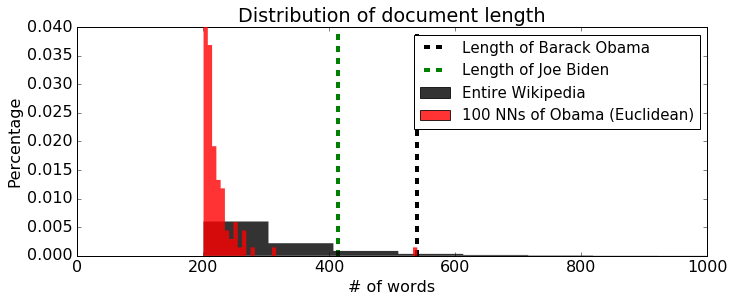

In [100]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

# cosine distances

In [101]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [102]:
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = wiki.join(neighbors, on='id')[['id', 'name', 'length', 'distance']].sort('distance')
print nearest_neighbors_cosine

+-------+-------------------------+--------+--------------------+
|   id  |           name          | length |      distance      |
+-------+-------------------------+--------+--------------------+
| 35817 |       Barack Obama      |  540   | -1.11022302463e-15 |
| 24478 |        Joe Biden        |  414   |   0.703138676734   |
| 38376 |      Samantha Power     |  310   |   0.742981902328   |
| 57108 |  Hillary Rodham Clinton |  580   |   0.758358397887   |
| 38714 | Eric Stern (politician) |  255   |   0.770561227601   |
| 46140 |       Robert Gibbs      |  257   |   0.784677504751   |
|  6796 |       Eric Holder       |  232   |   0.788039072943   |
| 44681 |  Jesse Lee (politician) |  216   |   0.790926415366   |
| 18827 |       Henry Waxman      |  279   |   0.798322602893   |
|  2412 |     Joe the Plumber     |  217   |   0.799466360042   |
+-------+-------------------------+--------+--------------------+
[100 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can

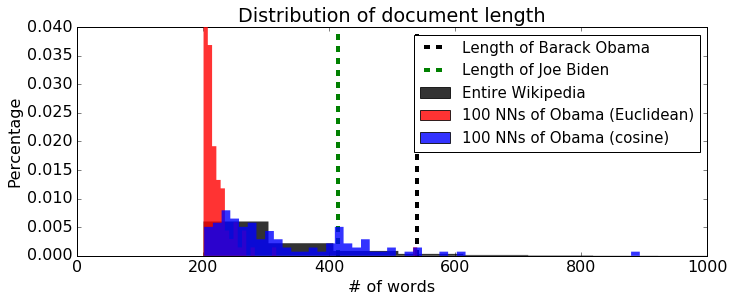

In [103]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

# problems with cosine distance

In [104]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

In [105]:
word_indices = [map_index_to_word[map_index_to_word['category']==word][0]['index'] for word in tweet.keys()]
tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]) )

In [111]:
from sklearn.metrics.pairwise import cosine_distances

obama_tf_idf = tf_idf[35817]
print cosine_distances(obama_tf_idf, tweet_tf_idf)

[[ 0.70591838]]


In [114]:
distances, indices = model2_tf_idf.kneighbors(obama_tf_idf, n_neighbors=10)
print distances

[[ -1.11022302e-15   7.03138677e-01   7.42981902e-01   7.58358398e-01
    7.70561228e-01   7.84677505e-01   7.88039073e-01   7.90926415e-01
    7.98322603e-01   7.99466360e-01]]
